# CS 534 Machine Learning

### Yicheng (Jason) Wang

### Problem 1:

Before calculating the mean vectors and co-variance matrices, we need to first extract data from the file. Therefore, I use pandas and numpy to convert them into multiple numpy arrays.

In [1]:
import pandas as pd 
import numpy as np

## Load Training Data and Test data
df = pd.read_csv('HW_1_training.txt', sep='\t')
X = np.array(df.loc[:, ['x1', 'x2']])
y = np.array(df['y'])

df = pd.read_csv('HW_1_testing.txt', sep='\t')
X_test = np.array(df.loc[:, ['x1', 'x2']])
y_test = np.array(df['y'])

Then, I write a method to calculate mean vectors and covariance matrices for both of the classes.

In [2]:
# calculate mean vector and co-variance matrix
def getMeanVectorsCovMatrices(X,y):
	meanVectors, covMatrices = [],[]
	for cl in np.unique(y):
		meanVectors.append(np.mean(X[y == cl], axis=0))
		covMatrices.append(np.cov(X[y == cl].T))

	return meanVectors, covMatrices

meanVectors, covMatrices = getMeanVectorsCovMatrices(X,y)

In [3]:
for i in range(2):
	print("The mean vector for class %d is: %s" % (i, meanVectors[i]))
	print("The covariance matrix for class %d is: " % i)
	print(covMatrices[i])
	print("")

The mean vector for class 0 is: [ 1.06242164  1.61910524]
The covariance matrix for class 0 is: 
[[ 4.79170095  0.90180838]
 [ 0.90180838  1.2945715 ]]

The mean vector for class 1 is: [ 1.13915258 -1.18380439]
The covariance matrix for class 1 is: 
[[ 0.7560476  -0.5093068 ]
 [-0.5093068   3.19387164]]



After I have the mean vectors and covariance matrices, I can generate multivariate normal distribution for both classes.

In [4]:
X_normal = np.concatenate([np.random.multivariate_normal(meanVectors[0], covMatrices[0], 1000),
                    np.random.multivariate_normal(meanVectors[1], covMatrices[1], 1000)])

y_normal = np.zeros(2000)
y_normal[1000:] = 1

At the first time, we train the model with no priors, which means the priors is 50% for each class.

In [5]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB(priors=[.5,.5])
clf.fit(X_normal,y_normal)

GaussianNB(priors=[0.5, 0.5])

Then we calculate the priors from the original data set and use that as the priors to train the model again.

In [6]:
# Calculate priors
p0 = list(y).count(0)*1./y.size
priors = [p0, 1-p0]

clf2 = GaussianNB(priors=priors)
clf2.fit(X_normal,y_normal)

GaussianNB(priors=[0.6153846153846154, 0.3846153846153846])

After fitting the two model, we can plot the decision area in both cases. For the plot method, I partly use the code from Python Machine Learing ed2. You can perceive a tiny difference on the decision boundary.

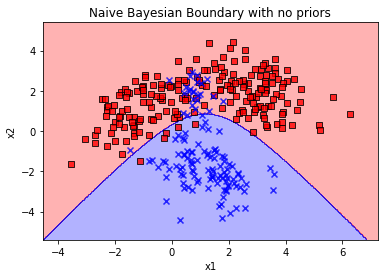

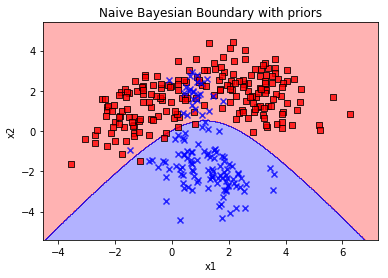

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
	markers = ('s', 'x', 'o', '^', 'v')
	colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
	cmap = ListedColormap(colors[:len(np.unique(y))])

	# plot the decision surface
	x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
	x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
	xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
	                       np.arange(x2_min, x2_max, resolution))

	Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
	Z = Z.reshape(xx1.shape)
	plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
	plt.xlim(xx1.min(), xx1.max())
	plt.ylim(xx2.min(), xx2.max())

	for idx, cl in enumerate(np.unique(y)):
		plt.scatter(x=X[y == cl, 0], 
		        y=X[y == cl, 1],
		        alpha=0.8, 
		        c=colors[idx],
		        marker=markers[idx], 
		        label=cl, 
		        edgecolor='black')

	plt.xlabel('x1')
	plt.ylabel('x2')
    
plt.figure(1)
plt.title('Naive Bayesian Boundary with no priors')
plot_decision_regions(X, y, classifier=clf)

plt.figure(2)
plt.title('Naive Bayesian Boundary with priors')
plot_decision_regions(X, y, classifier=clf2)
plt.show()

Finally, I calculate the error rate for both cases. They are the same in this setting.

In [8]:
## Calculate Test Error
print('The classification error rate for Bayesian Decision Boundary without priors is: %.2f'
				 %(1-clf.score(X_test,y_test)))
print('The classification error rate for Bayesian Decision Boundary with priors is: %.2f' 
				%(1-clf2.score(X_test,y_test)))

The classification error rate for Bayesian Decision Boundary without priors is: 0.06
The classification error rate for Bayesian Decision Boundary with priors is: 0.06


### Problem 2:

In this problem, we are required to use gaussian kernel to perform kernel density estimation on the training data with three different bandwidth (0.1, 1, 10). Therefore, I create a density plot for each case to visualize the distribution. The order of the graph is (bw = 0.1, 1, 1).

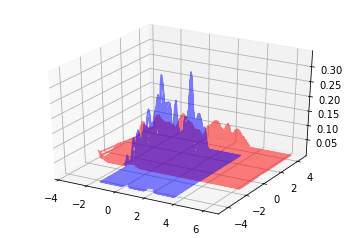

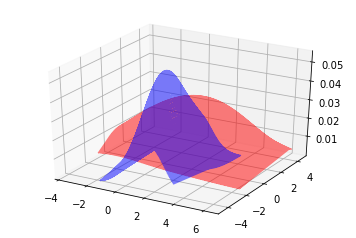

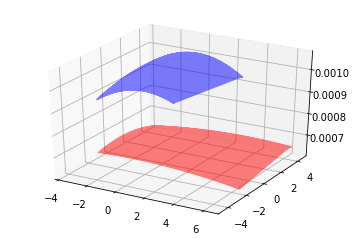

In [9]:
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D

def plotpdf(bw, kernels):
	'''
	Plotting pdf for each class estimated by Gaussian KDE
	'''
	for i in range(2):
		x1, x2 = X[y==i, 0], X[y==i, 1]
		values = np.vstack([x1,x2])
		kernels.append(gaussian_kde(values, bw_method=bw))

		xmin, xmax = x1.min(), x1.max()
		ymin, ymax = x2.min(), x2.max()

		A, B = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
		positions = np.vstack([A.ravel(), B.ravel()])
		kernel = kernels[i]
		ax.plot(positions[0], positions[1], kernel(positions),c=colors[i], alpha=0.5)

colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
for bw in (0.1, 1, 10):
	fig = plt.figure()
	ax = fig.add_subplot(111, projection='3d')
	kernels = []
	plotpdf(bw, kernels)

plt.show()

We can perceive from the graph above that when the bandwidth increase, the distribution is more smooth around the mean. After perceive the kernel density estimation, we plot the test points according to each bandwidth and calculate the test error rate.

The classification error rate for bandwidth = 0.1 is 0.02
The classification error rate for bandwidth = 1 is 0.03
The classification error rate for bandwidth = 10 is 0.31


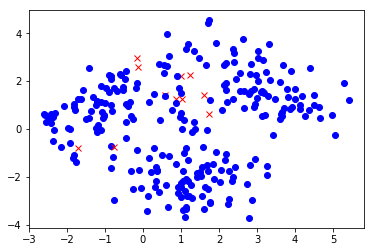

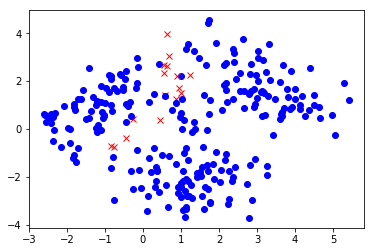

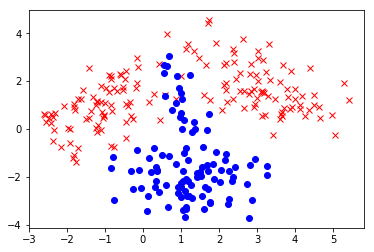

In [10]:
def plotTestPoints(kernels):
	## Plot test points
 	for i in range(2):
		x1, x2 = X[y==i, 0], X[y==i, 1]
		values = np.vstack([x1,x2])
		kernels.append(gaussian_kde(values, bw_method=bw))
        
	k1, k2 = kernels
	count = 0.0
	for index, i in enumerate(X_test):
		resClass = 0 if k1(i) > k2(i) else 1
		marker = 'o'
		color = 'blue'
		if resClass != y_test[index]:
			marker = 'x'
			color = 'red'
			count += 1

		ax.plot(i[0], i[1], c=color, marker=marker)
	return count

for bw in (0.1, 1, 10):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    kernels = []
    
    count = plotTestPoints(kernels)
    print("The classification error rate for bandwidth = %s is %.2f" %(bw, count/X_test.size))

plt.show()

The red cross is the data misclassified and the blue dot is the data classified correctly. In this case, when the bandwidth is 0.1, the test accuracy is the best.

### Problem 3:

The KNN implementation is as following, I use a class as a wrapper:

In [11]:
class Knn(object):

	def __init__(self, X, y, K):
		self.X = X
		self.y = y
		self.K = K
		self.res = np.array([])

	def predict(self, x):
		res = []
		for p in x:
			distances = np.array([np.linalg.norm(i-p) for i in self.X])
			kIndex = distances.argsort()[:self.K]
			values = y[kIndex]
			res.append(0 if np.sum(values) <= values.size // 2 else 1)

		self.res = np.array(res)
		return np.array(res)

	def getSensitivity(self, y_test):
		return np.dot(self.res, y_test)/y_test.sum()

	def getFDR(self, y_test):
		return 1 - self.getSensitivity(y_test)

	def getSpecificity(self, y_test):
		count = 0
		for i in range(y_test.size):
			count += self.res[i] == 0 and y_test[i] == 0

		return count / list(y_test).count(0)

Then I classify the test data in three cases: (a) K=1, (b) K=5, (c) K=10, and also calculate the correspoding sensitiviy, specificity and FDR rate in each case.

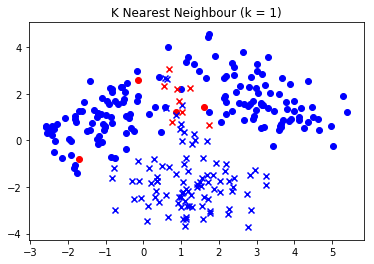

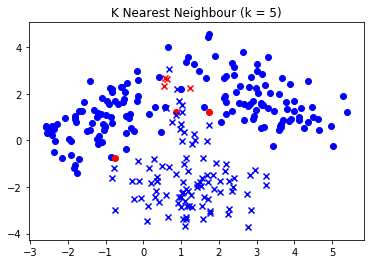

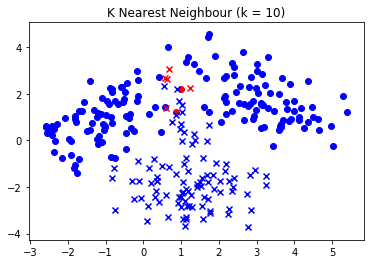

In [15]:
## helper method for plotting test data
def plotTestData(X_test, y_test, res):
	fig = plt.figure()
	ax = fig.add_subplot(111)

	for index, (i,j) in enumerate(X_test):
		color = 'blue' if y_test[index] == res[index] else 'red'
		marker = 'x' if y_test[index] else 'o'
		ax.scatter(i,j, c=color, marker=marker)
    

## Load Data
df = pd.read_csv('HW_1_training.txt', sep='\t')
X = np.array(df.loc[:, ['x1', 'x2']])
y = np.array(df['y'])

df = pd.read_csv('HW_1_testing.txt', sep='\t')
X_test = np.array(df.loc[:, ['x1', 'x2']])
y_test = np.array(df['y'])

for k in (1,5,10):
	## Initialize Classifier
	clf = Knn(X, y, k)
	res = clf.predict(X_test)

	## Plot Data
	plotTestData(X_test, y_test, res)
	plt.title("K Nearest Neighbour (k = %s)" %k)

plt.show()

When k = 1<br>
The sensitivity rate is 0.92<br>
The specificity rate is 0.97<br>
The false discovery rate rate is 0.08<br>
<br>
When k = 5<br>
The sensitivity rate is 0.96<br>
The specificity rate is 0.98<br>
The false discovery rate rate is 0.04<br>
<br>
When k = 10<br>
The sensitivity rate is 0.95<br>
The specificity rate is 0.99<br>
The false discovery rate rate is 0.05